In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df1 = pd.read_csv('../data/results/XKF1_merged.csv')
df2 = pd.read_csv('../data/results/XKF2_merged.csv')

select_col1 = ['Roll', 'Pitch', 'GX', 'GY', 'GZ'] # roll, pitch, 각속도
select_col2 = ['AX', 'AY', 'AZ', 'label'] # 가속도

concat_df = pd.concat([df1[select_col1], df2[select_col2]], axis=1)

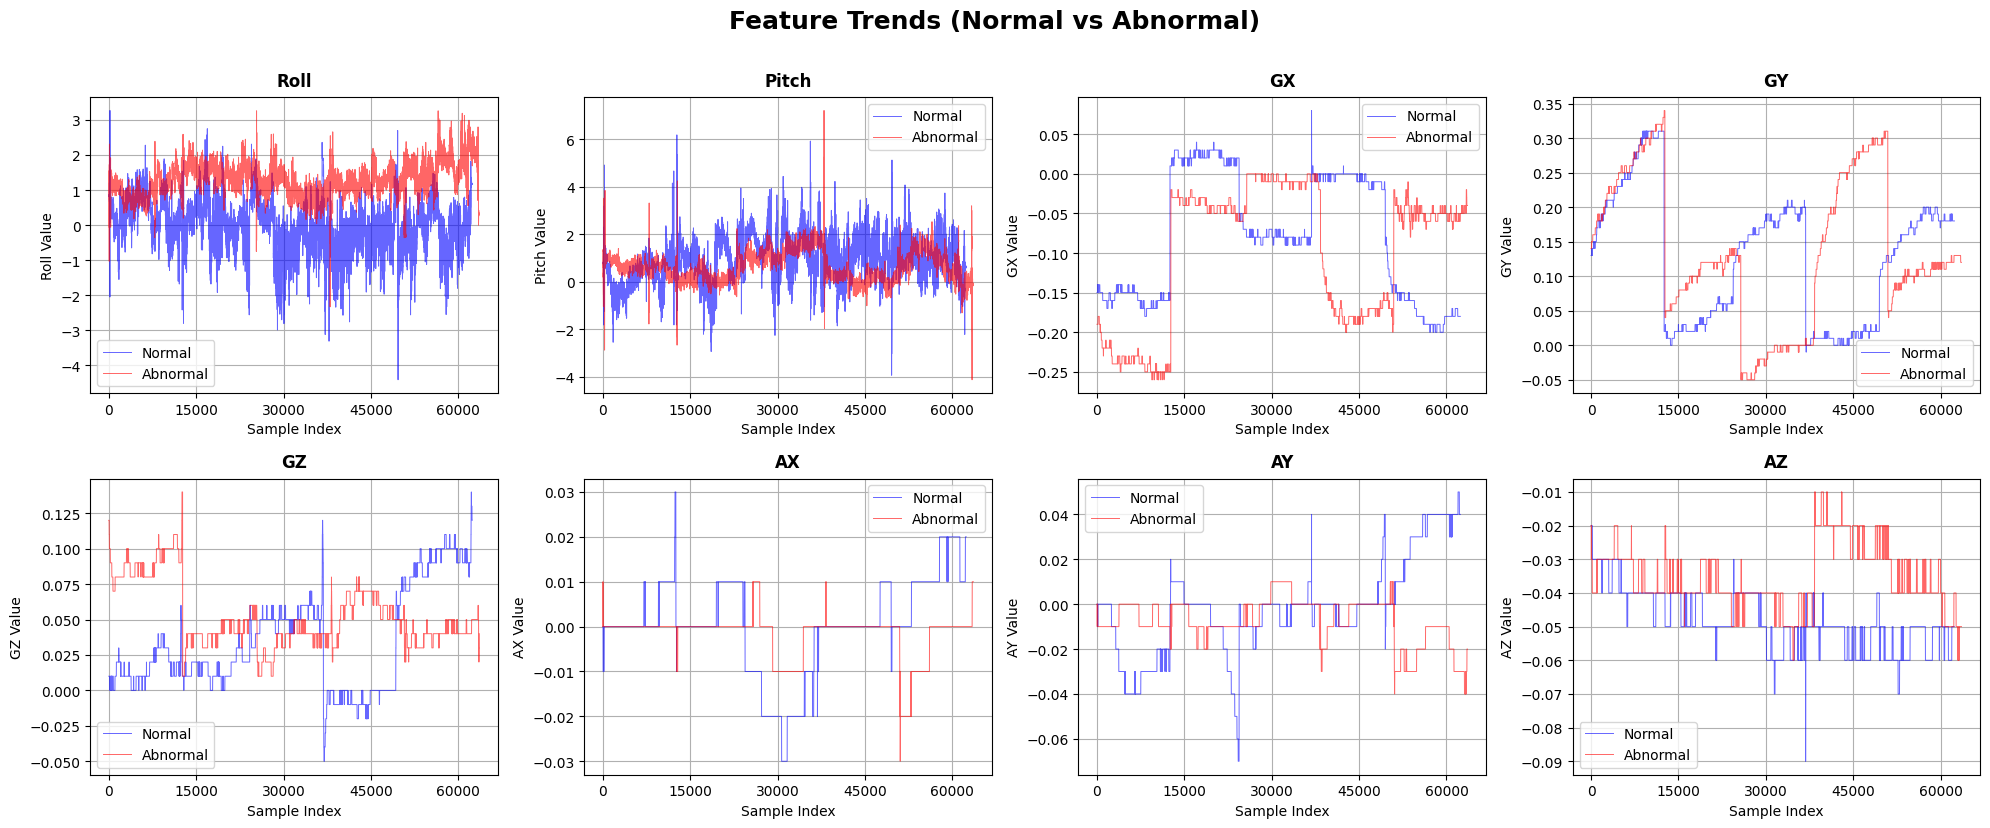

In [105]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_feature_trend(df, features, label_col='label', title='Feature Trends (Normal vs Abnormal)'):
    num_cols = 4
    num_rows = (len(features) + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axs = axs.flatten()

    # 레이블 분리
    normal = df[df[label_col] == 0].reset_index(drop=True)
    abnormal = df[df[label_col] == 1].reset_index(drop=True)

    for i, feature in enumerate(features):
        ax = axs[i]

        # x축: 각각 0부터 시작
        x_normal = range(len(normal))
        x_abnormal = range(len(abnormal))

        ax.plot(x_normal, normal[feature], color='blue', alpha=0.6, linewidth=0.7, label='Normal')
        ax.plot(x_abnormal, abnormal[feature], color='red', alpha=0.6, linewidth=0.7, label='Abnormal')

        ax.set_title(f'{feature}', fontsize=12, fontweight="bold", pad=8)
        ax.set_xlabel('Sample Index')
        ax.set_ylabel(f'{feature} Value')
        ax.grid(True)
        ax.legend()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

    # 빈 subplot 제거
    for j in range(len(features), len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle(title, fontsize=18, fontweight="bold", y=1.03)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


plot_feature_trend(
df=concat_df,
features=['Roll', 'Pitch', 'GX', 'GY', 'GZ', 'AX', 'AY', 'AZ']
)



In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 정상 / 이상 분리
nor_df = concat_df.loc[concat_df['label'] == 0]
ab_df = concat_df.loc[concat_df['label'] == 1]

# 정상 데이터 → 학습용 80%, 테스트용 20%
nor_trn, nor_tst = train_test_split(nor_df, test_size=0.2, random_state=42)
nor_tst = nor_tst.drop(columns=['label'])

# 이상 데이터에서 정상 테스트셋과 같은 수만큼 샘플링
ab_tst = ab_df.sample(n=len(nor_tst), random_state=42).drop(columns=['label'])

# 학습을 위해 라벨 제거
X_trn = nor_trn.drop(columns=['label'])

# 확인
print("정상(전체):", len(nor_df))
print("이상(전체):", len(ab_df))
print("정상 훈련용:", len(nor_trn))
print("테스트용 정상:", len(nor_tst))
print("테스트용 이상:", len(ab_tst))


In [ ]:
import matplotlib.pyplot as plots
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np  


# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 2),
            nn.ReLU(),
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


# 훈련 데이터로 테스트 복원 오차가 큰 샘플 찾기
def validation(trn_tensor):
    with torch.no_grad():
        recon = model(trn_tensor)
        loss_each = ((trn_tensor - recon) ** 2).mean(dim=1)
        threshold = torch.quantile(loss_each, 0.95)  # 상위 5%를 이상치로 간주
        anomalies = loss_each > threshold

    return loss_each.cpu().numpy(), threshold.item(), anomalies.cpu().numpy()

# 정상+비정상 데이터로 테스트
def evaluation(tst_tensor, y_true, threshold):
    model.eval()

    with torch.no_grad():
        recon = model(tst_tensor)
        recon_error = ((tst_tensor - recon) ** 2).mean(dim=1).cpu().numpy()

    y_pred = (recon_error > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal'], output_dict=True)

    return recon_error


def plot_results(recon_error, threshold, y_true, y_pred, cm):
    plt.figure(figsize=(10, 4))
    plt.plot(recon_error, label='Reconstruction MSE')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title("Reconstruction Error (Test Set)")
    plt.xlabel("Sample Index")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
    disp.plot(cmap='YlGnBu')
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

params = {'batch_size': 1024,
          'lr': 1e-5,
          'epochs': 500
}

scaler = MinMaxScaler()
scaled_X_trn = scaler.fit_transform(X_trn)

X_trn_tensor = torch.tensor(scaled_X_trn, dtype=torch.float32)

trn_dataset = TensorDataset(X_trn_tensor)
trn_loader = DataLoader(trn_dataset, batch_size=params['batch_size'], shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 초기화
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

loss_lst = []

epoch_bar = tqdm(range(params['epochs']), desc="Training")

for epoch in epoch_bar:
    model.train()
    epoch_loss = 0

    for batch in trn_loader:
        x_batch = batch[0].to(device)
        
        output = model(x_batch)
        loss = criterion(output, x_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(trn_loader)
    loss_lst.append(avg_loss)

    epoch_bar.set_postfix(loss=avg_loss)


Using device: cuda


Training: 100%|██████████| 500/500 [01:40<00:00,  4.97it/s, loss=0.00739]


In [115]:
def compute_threshold(model, trn_tensor, quantile=0.95):
    model.eval()
    with torch.no_grad():
        recon = model(trn_tensor.to(device))
        loss_each = ((trn_tensor.to(device) - recon) ** 2).mean(dim=1)
        threshold = torch.quantile(loss_each, quantile)
    return threshold.item()


In [116]:
q = 0.95

threshold = compute_threshold(model, X_trn_tensor, quantile=q)
print(f"Threshold ({round(q*100)}% quantile): {threshold:.6f}")

Threshold (95% quantile): 0.017731


In [117]:
def evaluate_anomaly(model, tst_tensor, threshold):
    model.eval()
    with torch.no_grad():
        recon = model(tst_tensor.to(device))
        recon_error = ((tst_tensor.to(device) - recon) ** 2).mean(dim=1).cpu().numpy()
        y_pred = (recon_error > threshold).astype(int)  # 1: 이상, 0: 정상
    return recon_error, y_pred

# recon_error, y_pred = evaluate_anomaly(model, X_tst_tensor, threshold)



In [118]:
def predict_anomalies(model, tst_tensor, threshold, device):
    model.eval()
    with torch.no_grad():
        recon = model(tst_tensor.to(device))
        recon_error = ((tst_tensor.to(device) - recon) ** 2).mean(dim=1).cpu().numpy()
        y_pred = (recon_error > threshold).astype(int)
    return recon_error, y_pred

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_predictions(y_true, y_pred):
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
    disp.plot(cmap='YlGnBu')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compare_confusion_matrices(y_true_normal, y_pred_normal, y_true_abnormal, y_pred_abnormal, batch_size, epochs, lr):
    # 혼동 행렬 계산
    cm_normal = confusion_matrix(y_true_normal, y_pred_normal)
    cm_abnormal = confusion_matrix(y_true_abnormal, y_pred_abnormal)

    # 시각화
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # 정상
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_normal, display_labels=["Normal", "Anomaly"])
    disp1.plot(ax=axs[0], cmap='YlGnBu', colorbar=False)
    axs[0].set_title("Confusion Matrix (Normal)")

    # 이상
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_abnormal, display_labels=["Normal", "Anomaly"])
    disp2.plot(ax=axs[1], cmap='YlGnBu', colorbar=False)
    axs[1].set_title("Confusion Matrix (Abnormal)")

    suptitle = f"Confusion Matrices\n(Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {lr})"
    plt.suptitle(suptitle, fontsize=14, fontweight="bold", y=1.05)

    plt.tight_layout()
    plt.show()

    # 성능 지표 출력
    print("=== 정상 조건 성능 지표 ===")
    print(classification_report(y_true_normal, y_pred_normal, target_names=["Normal", "Anomaly"]))

    print("=== 이상 조건 성능 지표 ===")
    print(classification_report(y_true_abnormal, y_pred_abnormal, target_names=["Normal", "Anomaly"]))


In [129]:
scaled_nor_tst = scaler.transform(nor_tst)
nor_tst_tensor = torch.tensor(scaled_nor_tst, dtype=torch.float32)


scaled_ab_tst = scaler.transform(ab_tst)
ab_tst_tensor = torch.tensor(scaled_ab_tst, dtype=torch.float32)


nor_recon_error, nor_y_pred = predict_anomalies(model, nor_tst_tensor, threshold, device)
nor_y_true = np.zeros_like(nor_y_pred)

ab_recon_error, ab_y_pred = predict_anomalies(model, ab_tst_tensor, threshold, device)
ab_y_true = np.ones_like(ab_y_pred)

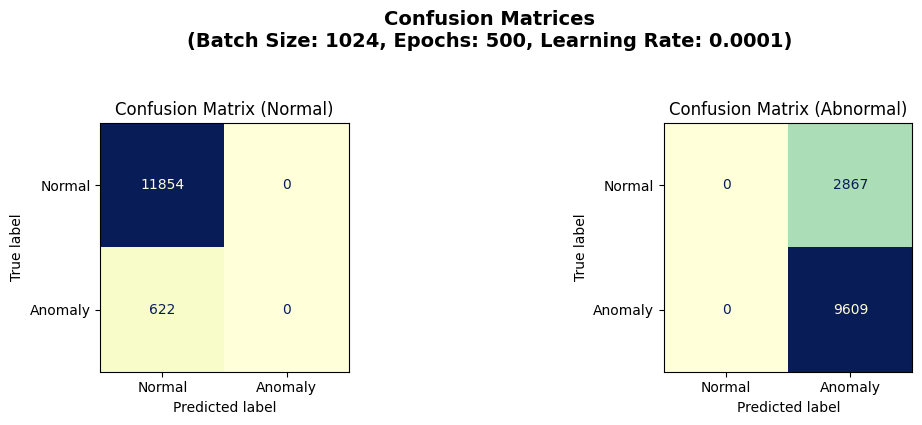

=== 정상 조건 성능 지표 ===
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97     11854
     Anomaly       0.00      0.00      0.00       622

    accuracy                           0.95     12476
   macro avg       0.48      0.50      0.49     12476
weighted avg       0.90      0.95      0.93     12476

=== 이상 조건 성능 지표 ===
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      2867
     Anomaly       0.77      1.00      0.87      9609

    accuracy                           0.77     12476
   macro avg       0.39      0.50      0.44     12476
weighted avg       0.59      0.77      0.67     12476



/home/seobin1027/miniconda3/envs/drone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/seobin1027/miniconda3/envs/drone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/seobin1027/miniconda3/envs/drone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [ ]:
compare_confusion_matrices(nor_y_pred, nor_y_true, ab_y_pred, ab_y_true, **params)

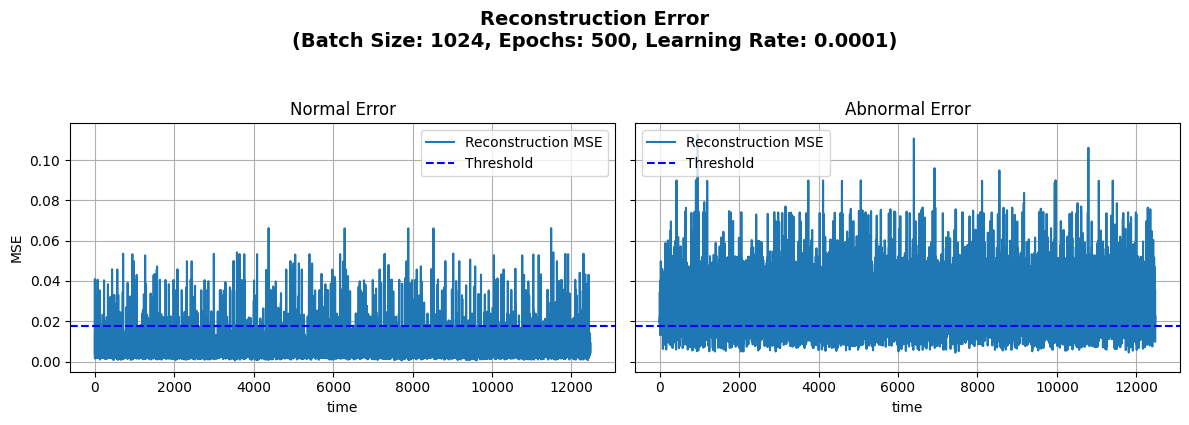

In [ ]:
import matplotlib.pyplot as plt

def plot_mse_comparison(normal_error, abnormal_error, threshold, batch_size, epochs, lr):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # 정상 데이터
    axs[0].plot(normal_error, label='Reconstruction MSE')
    axs[0].axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
    axs[0].set_title('Normal Error')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('MSE')
    axs[0].legend()
    axs[0].grid(True)

    # 이상 데이터
    axs[1].plot(abnormal_error, label='Reconstruction MSE')
    axs[1].axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
    axs[1].set_title('Abnormal Error')
    axs[1].set_xlabel('time')
    axs[1].legend()
    axs[1].grid(True)

    suptitle = f"Reconstruction Error\n(Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {lr})"
    plt.suptitle(suptitle, fontsize=14, fontweight="bold", y=1.05)

    plt.tight_layout()
    plt.show()

plot_mse_comparison(
    normal_error=nor_recon_error, 
    abnormal_error=ab_recon_error, 
    threshold=threshold,
    **params
)


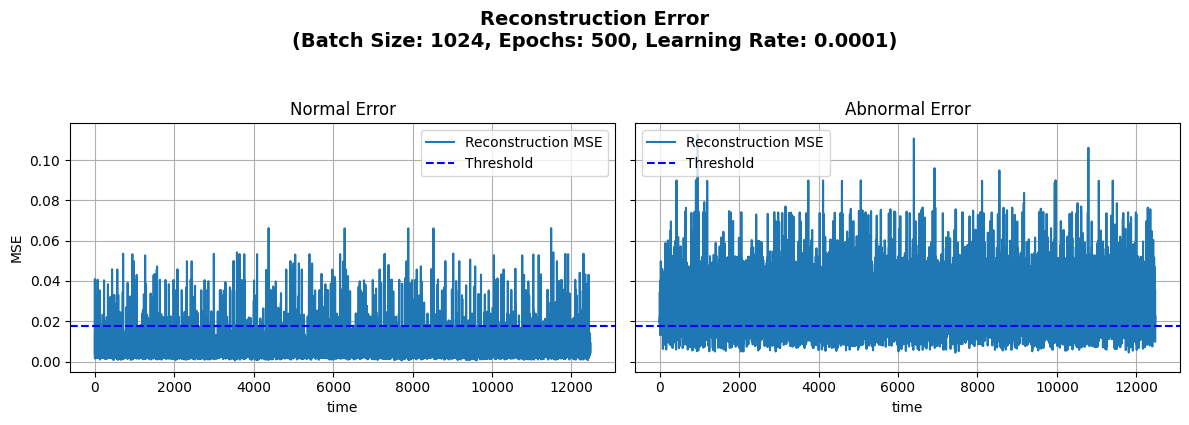

In [127]:
plot_mse_comparison(
    normal_error=nor_recon_error, 
    abnormal_error=ab_recon_error, 
    threshold=threshold
)

In [ ]:
plt.plot(recon_error, label="Reconstruction Error")
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Sample Index")
plt.ylabel("MSE")
plt.legend()
plt.title("Reconstruction MSE (Validation Set)")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix
cm = confusion_matrix(y_tst, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.show()

# classification report
print("=== Classification Report ===")
print(classification_report(y_tst, y_pred, target_names=["Normal", "Anomaly"]))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 예시 데이터 (정규화된 센서 데이터)
X = np.random.rand(1000, 10)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, 10),
            nn.Sigmoid()  # 입력이 0~1일 경우
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# 모델 초기화
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습
for epoch in range(50):
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 이상 탐지: 복원 오차가 큰 샘플 찾기
with torch.no_grad():
    recon = model(X_tensor)
    loss_each = ((X_tensor - recon) ** 2).mean(dim=1)
    threshold = torch.quantile(loss_each, 0.95)  # 상위 5%를 이상치로 간주
    anomalies = loss_each > threshold
